In [167]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobilities, _ = load_od_mobilities()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

/Users/Ronan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [56]:
N_DAYS = 21
ONSET_THRESH = 3
GROWTH_THRESH = 0

In [57]:
## Get death dataframe date columns
death_dates = get_date_columns(deaths, return_dtimes=False)

## Moving average (weekly) mobility
od_mobilities_ma = od_mobilities.copy()
od_mobilities_ma[od_mobilities_ma.columns[1:]] = od_mobilities[od_mobilities.columns[1:]].rolling(7, center=True, axis=1).mean()
od_mobilities_ma = od_mobilities_ma.dropna(axis=1)

In [58]:
def get_onset_date(row, thresh):
    above = row[row >= thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [59]:
deaths_df = deaths[['FIPS']+death_dates]
deaths_df.dropna(subset=['FIPS'], inplace=True)
deaths_df = deaths_df.astype({'FIPS':int})

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row, thresh=ONSET_THRESH), axis=1)

## Drop counties with no onset
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

## Only counties with N_DAYS worth of data after onset
deaths_df = deaths_df[deaths_df['onset'].apply(
    lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= N_DAYS
)]

## Remove counties with growth decrease
deaths_df = deaths_df[
    deaths_df.apply(
        lambda r: r[[d for d in death_dates if 
            str2date(d) >= str2date(r['onset']) and 
            str2date(d) <= lag_date(str2date(r['onset']
        ), 
        lag=N_DAYS, backwards=False)
                    ]].diff().min() >= GROWTH_THRESH, axis=1
    )
]

## Get the number of deaths at N_DAYS from onset
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: r[lag_date(str2date(r['onset']), lag=N_DAYS, backwards=False, return_date=False)], axis=1
)

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths', 'onset']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

## OD baseline
od_dates = get_date_columns(od_mobilities, return_dtimes=False)
od_mobilities['OD_baseline'] = od_mobilities.apply(lambda x: x[od_dates[:14]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, od_mobilities[['FIPS', 'OD_baseline']], on='FIPS')

## OD at onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][row['onset']].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_at_onset'] = new_row

## OD 2 weeks before onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        lag_onset = lag_date(row['onset'], lag=14, backwards=True, return_date=False)
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][lag_onset].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_2wk_before_onset'] = new_row

## OD 2 weeks after onset
new_row = []
for i,row in cum_deaths.iterrows():
    try:
        lag_onset = lag_date(row['onset'], lag=14, backwards=False, return_date=False)
        od = od_mobilities_ma[od_mobilities_ma['FIPS']==row['FIPS']][lag_onset].iloc[0]
    except:
        od = np.nan
    new_row.append(od)
cum_deaths['OD_2wk_after_onset'] = new_row

## static features
static_features = counties[
    ['FIPS',
     'Rural-urban_Continuum Code_2013',
     'Density per square mile of land area - Population',
     'Percent of adults with less than a high school diploma 2014-18',
     'PCTPOV017_2018',
     'Unemployment_rate_2018',
     'Total_age65plus', 
     'POP_ESTIMATE_2018']
]
static_features = static_features.dropna()
cum_deaths = cum_deaths.merge(static_features, on="FIPS")

## normalize
cum_deaths['cum_deaths_normalized'] = cum_deaths['cum_deaths'] / cum_deaths['POP_ESTIMATE_2018']
cum_deaths['OD_baseline_normalized'] = cum_deaths['OD_baseline'] / cum_deaths['POP_ESTIMATE_2018']
cum_deaths['OD_at_onset_normalized'] = cum_deaths['OD_at_onset'] / cum_deaths['OD_baseline']
cum_deaths['OD_2wk_before_onset_normalized'] = cum_deaths['OD_2wk_before_onset'] / cum_deaths['OD_baseline']
cum_deaths['OD_2wk_after_onset_normalized'] = cum_deaths['OD_2wk_after_onset'] / cum_deaths['OD_baseline']

cum_deaths['HospCt_normalized'] = cum_deaths['HospCt'] / cum_deaths['POP_ESTIMATE_2018']
cum_deaths['Beds_normalized'] = cum_deaths['Beds'] / cum_deaths['POP_ESTIMATE_2018']

## New Feature
cum_deaths['OD_baseline_density'] = cum_deaths['OD_baseline'] * cum_deaths['Density per square mile of land area - Population']

In [104]:
outliers = [36061, 6038, 17031, 48201]
cum_deaths = cum_deaths[~cum_deaths['FIPS'].isin(outliers)]

In [105]:
log_cols = ['cum_deaths',
            'cum_deaths_normalized',
            'OD_baseline',
            'OD_baseline_normalized',
            'Density per square mile of land area - Population',
            'POP_ESTIMATE_2018',
            'OD_2wk_before_onset',
            'OD_at_onset',
            'OD_2wk_after_onset',
            'OD_2wk_before_onset_normalized',
            'OD_at_onset_normalized',
            'OD_2wk_after_onset_normalized',
            'OD_baseline_density',
           ]
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')

In [74]:
cluster_cols = [
    'Rural-urban_Continuum Code_2013',
    'cum_deaths (log)',
    'Density per square mile of land area - Population',
    'POP_ESTIMATE_2018',
    'OD_baseline',
    'OD_2wk_before_onset_normalized',
    'OD_at_onset_normalized',
    'OD_2wk_after_onset_normalized',
]

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [65]:
X = cum_deaths[cluster_cols].values

In [66]:
pca = PCA(n_components=8)
scaler = StandardScaler()
Xhat = pca.fit_transform(scaler.fit_transform(X))

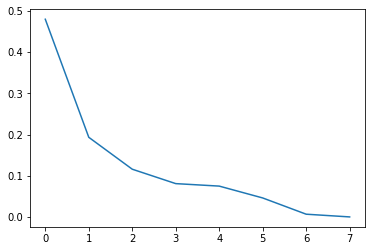

In [67]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [68]:
n_clusters = np.arange(2,12,1)
for n_clusters in n_clusters:
    clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(Xhat[:,:4])
    score = silhouette_score(Xhat[:,:2], clustering.labels_)
    print(f'{n_clusters}: {score}')

2: 0.4220959970544762
3: 0.44886595952398706
4: 0.44887307389023773
5: 0.41966879507855076
6: 0.39970676187060183
7: 0.3721655102306271
8: 0.3652962969408786
9: 0.34794850137201944
10: 0.36720419922320346
11: 0.3407543632109157


In [69]:
clustering = KMeans(n_clusters=4, random_state=0).fit(Xhat[:,:4])

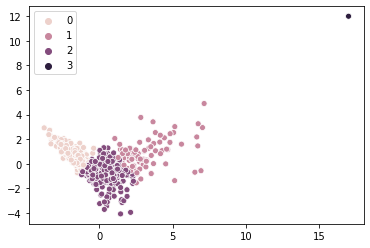

In [70]:
sns.scatterplot(Xhat[:,0], Xhat[:,1], hue=clustering.labels_)

## Parcellate on mobility

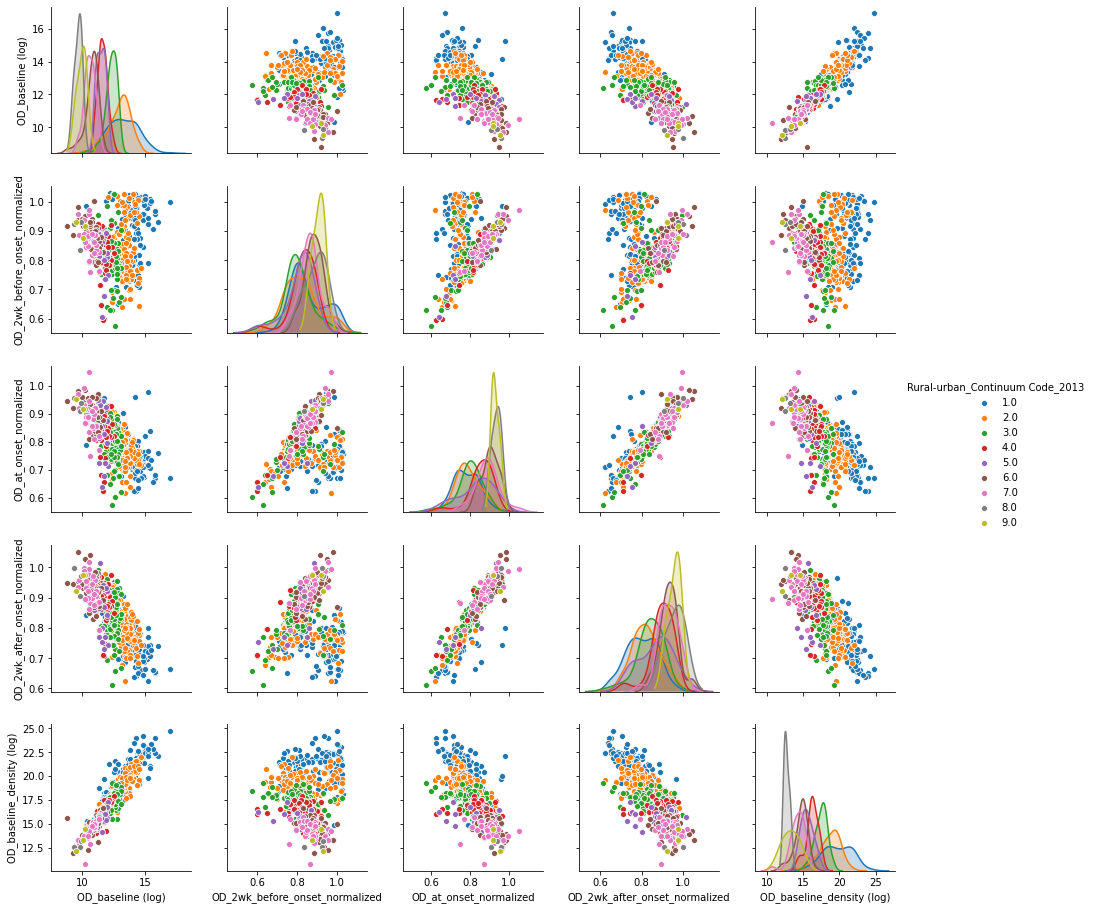

In [86]:
vars = [
    'OD_baseline (log)',
    'OD_2wk_before_onset_normalized',
    'OD_at_onset_normalized',
    'OD_2wk_after_onset_normalized',
    'OD_baseline_density (log)',
    #'Density per square mile of land area - Population (log)',
]
sns.pairplot(cum_deaths, vars=vars, hue='Rural-urban_Continuum Code_2013')

In [112]:
## Bins
N_BINS = 10
_, bins = np.histogram(cum_deaths['OD_at_onset (log)'], bins=N_BINS)
cum_deaths['binned_mobility'] = pd.cut(
    cum_deaths['OD_at_onset (log)'],
    bins=bins,
    labels=np.arange(1,len(bins)),
    include_lowest=True
)

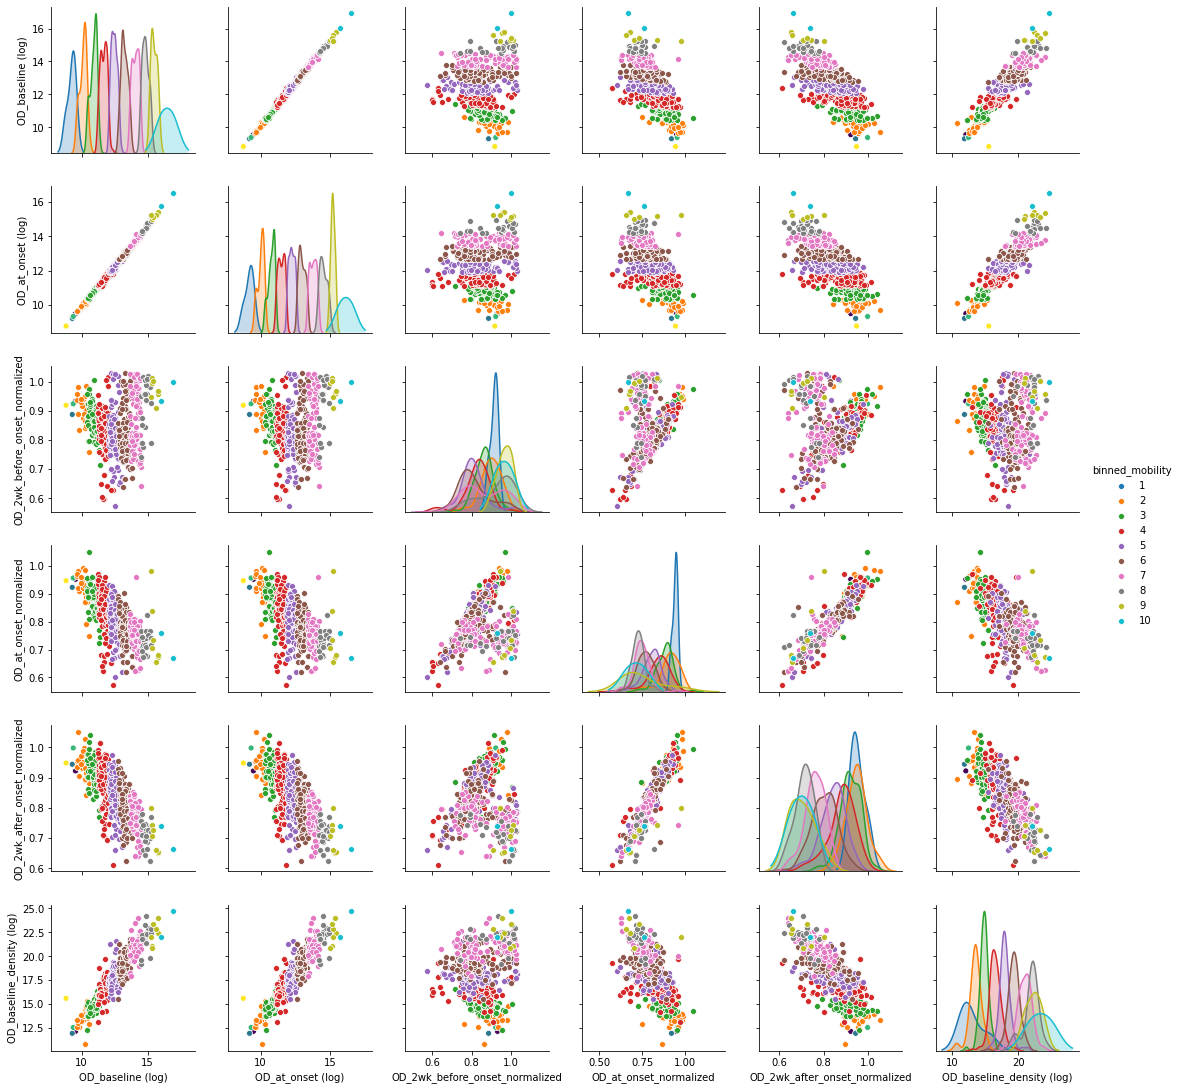

In [97]:
vars = [
    'OD_baseline (log)',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'OD_at_onset_normalized',
    'OD_2wk_after_onset_normalized',
    'OD_baseline_density (log)',
]
sns.pairplot(cum_deaths, vars=vars, hue='binned_mobility')

## Regress

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [177]:
## Bins
N_BINS = 10
_, bins = np.histogram(cum_deaths['OD_at_onset (log)'], bins=N_BINS)
cum_deaths['binned_mobility'] = pd.cut(
    cum_deaths['OD_at_onset (log)'],
    bins=bins,
    labels=np.arange(1,len(bins)),
    include_lowest=True
)

In [178]:
cum_deaths.groupby('binned_mobility').median()

,FIPS,cum_deaths,Beds,HospCt,OD_baseline,OD_at_onset,OD_2wk_before_onset,OD_2wk_after_onset,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,...,OD_baseline_normalized (log),Density per square mile of land area - Population (log),POP_ESTIMATE_2018 (log),OD_2wk_before_onset (log),OD_at_onset (log),OD_2wk_after_onset (log),OD_2wk_before_onset_normalized (log),OD_at_onset_normalized (log),OD_2wk_after_onset_normalized (log),OD_baseline_density (log)
binned_mobility,,,,,,,,,,,,,,,,,,,,,
1,21056.0,6.0,54.0,1.0,1.126508e+04,1.059610e+04,1.020560e+04,1.095173e+04,7.0,18.55,...,0.275969,2.885066,9.030509,9.228981,9.266669,9.299074,-0.082208,-0.051791,-0.055243,12.315863
2,22043.0,6.0,44.5,1.0,2.706210e+04,2.434575e+04,2.385959e+04,2.510726e+04,7.0,33.50,...,0.360234,3.510903,9.769555,10.079938,10.100060,10.130909,-0.107438,-0.085039,-0.051749,13.682768
3,26103.0,7.0,70.0,1.0,5.782735e+04,5.109925e+04,4.921065e+04,5.215822e+04,6.0,54.05,...,0.476285,3.989837,10.494418,10.803783,10.841480,10.862037,-0.141380,-0.115494,-0.082843,14.946558
4,34037.0,7.5,160.5,1.0,1.222919e+05,9.848493e+04,9.758827e+04,1.023228e+05,3.0,127.40,...,0.473055,4.847312,11.179374,11.488511,11.497626,11.535816,-0.177036,-0.157504,-0.119610,16.534883
5,28046.0,11.5,327.0,2.0,2.622087e+05,2.068753e+05,2.119354e+05,2.161776e+05,2.0,244.15,...,0.514684,5.497782,11.977161,12.264037,12.239864,12.283855,-0.217782,-0.206041,-0.161618,17.965930
6,28563.0,16.5,764.0,3.0,5.566157e+05,4.296701e+05,4.615899e+05,4.475998e+05,2.0,456.70,...,0.562251,6.124026,12.688628,13.042414,12.970766,13.011652,-0.226674,-0.256953,-0.216157,19.339225
7,25007.0,31.5,1730.0,7.0,1.358194e+06,9.951736e+05,1.159453e+06,1.004088e+06,1.0,1097.05,...,0.589446,7.000242,13.536737,13.963455,13.810671,13.819574,-0.179554,-0.288888,-0.270875,21.080351
8,13551.0,42.5,3867.0,13.5,2.768200e+06,1.973945e+06,2.686322e+06,1.987616e+06,1.0,1455.05,...,0.656258,7.282771,14.209925,14.803462,14.495488,14.502445,-0.043286,-0.319575,-0.334554,22.212469
9,12086.0,60.0,6217.0,23.0,5.028489e+06,4.054756e+06,5.039909e+06,3.657395e+06,1.0,912.90,...,0.715421,6.816626,14.785445,15.432899,15.215401,15.112262,-0.032719,-0.348560,-0.347129,22.389318


In [179]:
cum_deaths.columns

Index(['FIPS', 'cum_deaths', 'onset', 'Beds', 'HospCt', 'OD_baseline',
       'OD_at_onset', 'OD_2wk_before_onset', 'OD_2wk_after_onset',
       'Rural-urban_Continuum Code_2013',
       'Density per square mile of land area - Population',
       'Percent of adults with less than a high school diploma 2014-18',
       'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus',
       'POP_ESTIMATE_2018', 'cum_deaths_normalized', 'OD_baseline_normalized',
       'OD_at_onset_normalized', 'OD_2wk_before_onset_normalized',
       'OD_2wk_after_onset_normalized', 'HospCt_normalized', 'Beds_normalized',
       'OD_baseline_density', 'cum_deaths (log)',
       'cum_deaths_normalized (log)', 'OD_baseline (log)',
       'OD_baseline_normalized (log)',
       'Density per square mile of land area - Population (log)',
       'POP_ESTIMATE_2018 (log)', 'OD_2wk_before_onset (log)',
       'OD_at_onset (log)', 'OD_2wk_after_onset (log)',
       'OD_2wk_before_onset_normalized (log)', 'OD_at_onse

In [180]:
predictors = [
    'Beds_normalized',
    'HospCt_normalized',
    'Rural-urban_Continuum Code_2013',
    'Density per square mile of land area - Population',
    'POP_ESTIMATE_2018 (log)',
    'OD_2wk_before_onset_normalized',
    'OD_at_onset_normalized',
    'OD_2wk_after_onset_normalized',
    'OD_baseline (log)',
]
target = 'cum_deaths_normalized (log)'

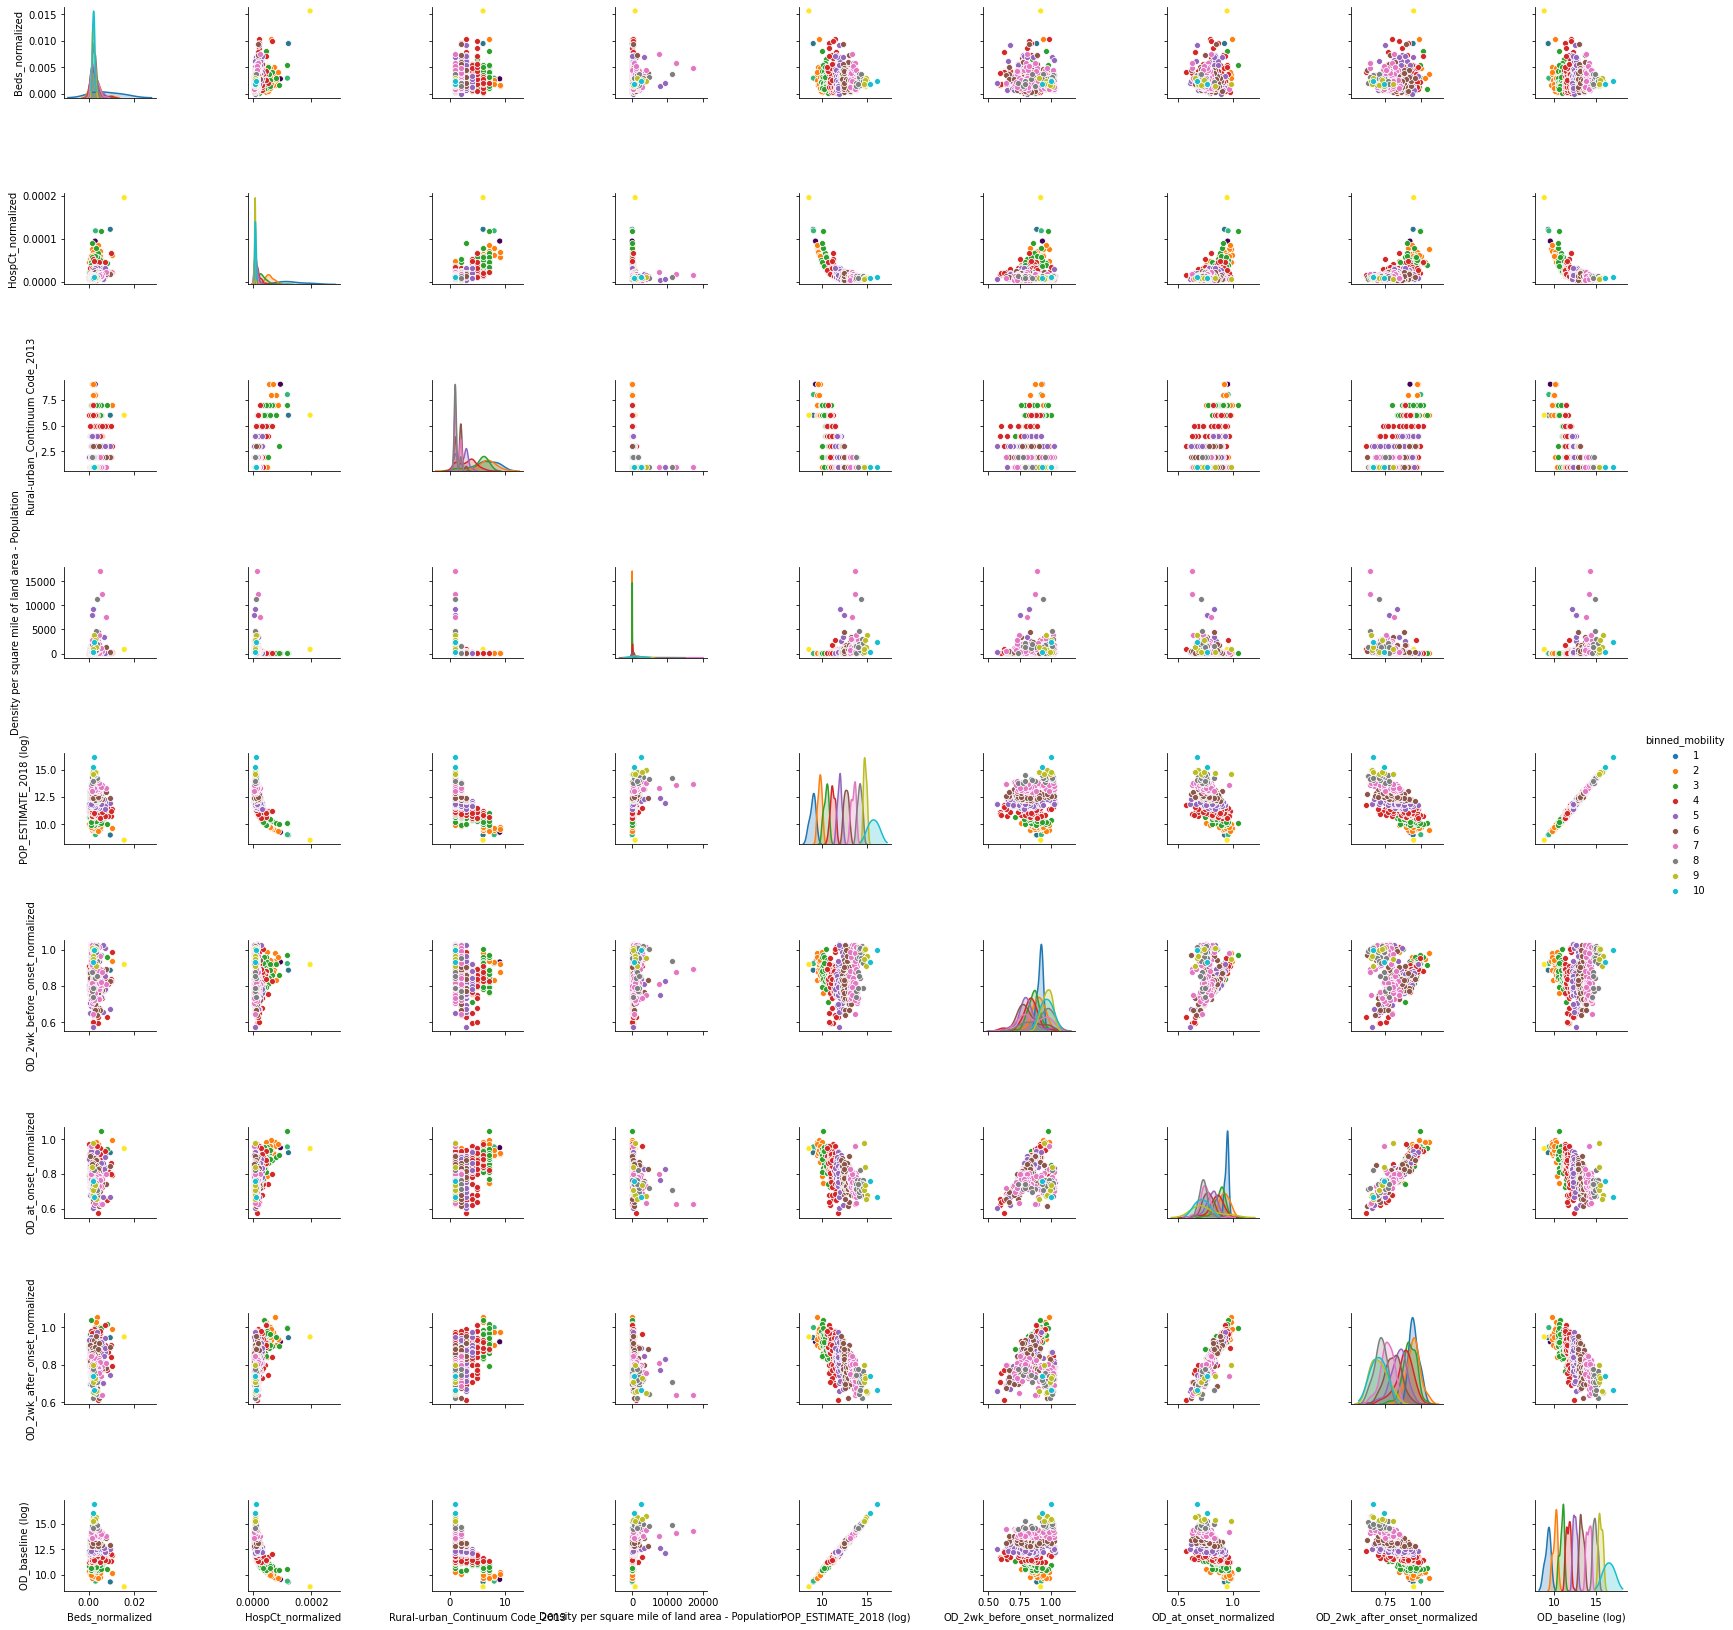

In [169]:
## Plot predictors on standardized scalet
# scaler = StandardScaler()
# temp_df = cum_deaths[['binned_mobility'] + predictors].copy()
# for g in groups:
#     temp =temp_df[temp_df['binned_mobility'] == g][predictors].values
#     temp_df[temp_df['binned_mobility'] == g][predictors] = scaler.fit_transform(temp)
# sns.pairplot(temp_df, vars=predictors, hue='binned_mobility')
sns.pairplot(cum_deaths, vars=predictors, hue='binned_mobility')

### Linear Reg, 10 Bins

In [181]:
scaler = StandardScaler()
clf = LinearRegression(normalize=False)
groups = np.arange(1,len(bins))

classifiers = []
scores = []
coefficients = []

for group in groups:
    print(f'######### Group {group} #########')
    if group in [1,9,10]:
        print(f'Group too small, skipping')
        scores.append(np.nan)
        coefficients.append(np.full(len(predictors), np.nan))
        continue

    temp = cum_deaths[cum_deaths['binned_mobility'] == group]
    X = temp[predictors]
    y = temp[target]
    
    X = scaler.fit_transform(X)
    
    clf = clf.fit(X,y)
    coefficients.append(clf.coef_)
    score = clf.score(X,y)
    scores.append(score)
    classifiers.append(clf)

######### Group 1 #########
Group too small, skipping
######### Group 2 #########
######### Group 3 #########
######### Group 4 #########
######### Group 5 #########
######### Group 6 #########
######### Group 7 #########
######### Group 8 #########
######### Group 9 #########
Group too small, skipping
######### Group 10 #########
Group too small, skipping


In [186]:
lr_coef_df = pd.DataFrame(
    np.hstack((np.asarray(groups)[:,None], np.asarray(scores)[:,None], coefficients)),
    columns = ['Group'] + ['Score'] + predictors
).set_index('Group')
lr_coef_df['Median Mobility'] = cum_deaths.groupby('binned_mobility').median()['OD_at_onset (log)']

In [187]:
lr_coef_df

,Score,Beds_normalized,HospCt_normalized,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,POP_ESTIMATE_2018 (log),OD_2wk_before_onset_normalized,OD_at_onset_normalized,OD_2wk_after_onset_normalized,OD_baseline (log),Median Mobility
Group,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.266669
2.0,0.561356,-0.043895,-2.129575,-0.217462,0.271196,-2.076032,-0.300242,-0.006217,-0.099093,-0.492774,10.100060
3.0,0.380296,-0.148075,0.018856,0.259672,0.117341,-0.774339,0.100196,-0.025803,-0.094428,0.593223,10.841480
4.0,0.169784,0.079152,0.003692,0.027569,0.009789,-0.015520,0.286282,-0.080371,-0.241279,-0.246210,11.497626
5.0,0.274555,0.130358,-0.038367,0.105385,0.047313,0.152070,0.064182,0.431283,-0.721158,-0.410412,12.239864
6.0,0.299543,-0.046590,0.150397,-0.015530,0.124181,0.054721,0.220416,0.455842,-0.725107,-0.170131,12.970766
7.0,0.362873,0.398087,-0.387695,-0.100874,-0.185544,0.294979,0.089823,-0.160572,-0.439121,-0.472740,13.810671
8.0,0.695920,0.197912,0.219924,-0.175225,0.388305,-0.226590,0.635679,0.139158,-0.243844,-0.181317,14.495488
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.215401


### Lasso 10 Bins

In [188]:
scaler = StandardScaler()
clf = Lasso(normalize=False)
gscv = GridSearchCV(clf, {'alpha':[0.01,0.1,1,10]})
groups = np.arange(1,len(bins))

classifiers = []
scores = []
coefficients = []

for group in groups:
    print(f'######### Group {group} #########')
    if group in [1,9,10]:
        print(f'Group too small, skipping')
        scores.append(np.nan)
        coefficients.append(np.full(len(predictors), np.nan))
        continue

    temp = cum_deaths[cum_deaths['binned_mobility'] == group]
    X = temp[predictors]
    y = temp[target]
    
    X = scaler.fit_transform(X)
    
    gscv = gscv.fit(X,y)
    best_clf = gscv.best_estimator_
    print(f'alpha = {gscv.best_params_["alpha"]}')
    
    best_clf = best_clf.fit(X,y)
    coefficients.append(best_clf.coef_)
    score = best_clf.score(X,y)
    scores.append(score)
    classifiers.append(best_clf)

######### Group 1 #########
Group too small, skipping
######### Group 2 #########
alpha = 1
######### Group 3 #########
alpha = 0.01
######### Group 4 #########
alpha = 0.01
######### Group 5 #########
alpha = 0.01
######### Group 6 #########
alpha = 0.01
######### Group 7 #########
alpha = 0.1
######### Group 8 #########
alpha = 0.1
######### Group 9 #########
Group too small, skipping
######### Group 10 #########
Group too small, skipping


In [189]:
lr_coef_df = pd.DataFrame(
    np.hstack((np.asarray(groups)[:,None], np.asarray(scores)[:,None], coefficients)),
    columns = ['Group'] + ['Score'] + predictors
).set_index('Group')
lr_coef_df['Median Mobility'] = cum_deaths.groupby('binned_mobility').median()['OD_at_onset (log)']

In [190]:
lr_coef_df

,Score,Beds_normalized,HospCt_normalized,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,POP_ESTIMATE_2018 (log),OD_2wk_before_onset_normalized,OD_at_onset_normalized,OD_2wk_after_onset_normalized,OD_baseline (log),Median Mobility
Group,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.266669
2.0,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,10.100060
3.0,0.366246,-0.086322,0.000000,0.242161,0.084092,-0.571358,0.032878,-0.044557,-0.031786,0.386641,10.841480
4.0,0.166636,0.075402,0.001030,0.012517,0.000000,-0.030562,0.231078,-0.010287,-0.247041,-0.211637,11.497626
5.0,0.262745,0.094596,-0.027076,0.071381,0.069321,0.041706,0.085853,0.214660,-0.503383,-0.301667,12.239864
6.0,0.296387,-0.017641,0.112151,-0.032144,0.114791,0.000000,0.232940,0.376023,-0.629112,-0.103065,12.970766
7.0,0.259339,0.000000,-0.047134,-0.081495,0.000000,-0.000000,0.046732,-0.000000,-0.338747,-0.000000,13.810671
8.0,0.646651,0.261526,0.000000,-0.000000,0.313927,-0.000000,0.495965,-0.000000,-0.138597,-0.055021,14.495488
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.215401


In [191]:
## Bins
N_BINS = 5
_, bins = np.histogram(cum_deaths['OD_at_onset (log)'], bins=N_BINS)
cum_deaths['binned_mobility'] = pd.cut(
    cum_deaths['OD_at_onset (log)'],
    bins=bins,
    labels=np.arange(1,len(bins)),
    include_lowest=True
)

In [192]:
cum_deaths.groupby('binned_mobility').median()

,FIPS,cum_deaths,Beds,HospCt,OD_baseline,OD_at_onset,OD_2wk_before_onset,OD_2wk_after_onset,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,...,OD_baseline_normalized (log),Density per square mile of land area - Population (log),POP_ESTIMATE_2018 (log),OD_2wk_before_onset (log),OD_at_onset (log),OD_2wk_after_onset (log),OD_2wk_before_onset_normalized (log),OD_at_onset_normalized (log),OD_2wk_after_onset_normalized (log),OD_baseline_density (log)
binned_mobility,,,,,,,,,,,,,,,,,,,,,
1,22043.0,6.0,44.5,1.0,2.465716e+04,2.292551e+04,2.249214e+04,2.409180e+04,7.0,30.80,...,0.336459,3.426327,9.738794,10.019984,10.039548,10.089187,-0.095823,-0.081067,-0.054339,13.555675
2,28086.0,7.0,120.5,1.0,9.247623e+04,7.746156e+04,7.534461e+04,8.145590e+04,4.0,93.75,...,0.474677,4.540614,10.966216,11.229824,11.257535,11.307817,-0.165404,-0.140408,-0.102261,15.965419
3,28054.0,13.0,468.5,2.0,3.647271e+05,2.861913e+05,2.959502e+05,3.021427e+05,2.0,317.65,...,0.541491,5.760945,12.257777,12.597938,12.564409,12.618642,-0.221823,-0.230303,-0.188076,18.500444
4,24757.5,36.5,1883.0,8.0,1.490800e+06,1.114760e+06,1.345097e+06,1.108458e+06,1.0,1253.25,...,0.610150,7.133464,13.628844,14.111976,13.924149,13.918453,-0.129762,-0.298890,-0.280863,21.366580
5,6073.0,69.0,6644.0,23.0,6.178732e+06,4.071769e+06,5.612105e+06,4.074634e+06,1.0,912.90,...,0.728066,6.816626,14.831314,15.540436,15.219588,15.220292,-0.032719,-0.348560,-0.347129,22.389318


### Lasso 5 Bins

In [193]:
scaler = StandardScaler()
clf = Lasso(normalize=False)
gscv = GridSearchCV(clf, {'alpha':[0.01,0.1,1,10]})
groups = np.arange(1,len(bins))

classifiers = []
scores = []
coefficients = []

for group in groups:
    print(f'######### Group {group} #########')
    temp = cum_deaths[cum_deaths['binned_mobility'] == group]
    print(f'Number of counties: {len(temp)}')
    X = temp[predictors]
    y = temp[target]
    
    X = scaler.fit_transform(X)
    
    gscv = gscv.fit(X,y)
    best_clf = gscv.best_estimator_
    print(f'alpha = {gscv.best_params_["alpha"]}')
    
    best_clf = best_clf.fit(X,y)
    coefficients.append(best_clf.coef_)
    score = best_clf.score(X,y)
    scores.append(score)
    classifiers.append(best_clf)

######### Group 1 #########
Number of counties: 28
alpha = 0.1
######### Group 2 #########
Number of counties: 214
alpha = 0.01
######### Group 3 #########
Number of counties: 278
alpha = 0.01
######### Group 4 #########
Number of counties: 102
alpha = 0.1
######### Group 5 #########
Number of counties: 9
alpha = 0.01


In [194]:
lr_coef_df = pd.DataFrame(
    np.hstack((np.asarray(groups)[:,None], np.asarray(scores)[:,None], coefficients)),
    columns = ['Group'] + ['Score'] + predictors
).set_index('Group')
lr_coef_df['Median Mobility'] = cum_deaths.groupby('binned_mobility').median()['OD_at_onset (log)']

In [195]:
lr_coef_df

,Score,Beds_normalized,HospCt_normalized,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,POP_ESTIMATE_2018 (log),OD_2wk_before_onset_normalized,OD_at_onset_normalized,OD_2wk_after_onset_normalized,OD_baseline (log),Median Mobility
Group,,,,,,,,,,,
1.0,0.229348,-0.000000,0.000000,-0.062387,0.000000,-0.000000,0.000000,0.000000,-0.014673,-0.149809,10.039548
2.0,0.271018,0.013138,-0.000000,0.104709,0.032921,-0.314732,0.179977,-0.106890,-0.077326,-0.000000,11.257535
3.0,0.270223,0.046256,0.018748,0.031530,0.088960,0.000000,0.163566,0.357809,-0.655004,-0.303804,12.564409
4.0,0.267966,0.000000,-0.019396,-0.097727,0.028527,-0.000000,0.100092,-0.000000,-0.340912,-0.162083,13.924149
5.0,0.693601,0.594746,-0.324904,0.000000,-0.414071,0.000000,0.066793,0.087206,-0.101696,0.096852,15.219588
